In [1]:
#https://levelup.gitconnected.com/painless-classification-model-using-rnn-b90cb0982543
import pandas as pd
import numpy as np
from nltk import word_tokenize
import tensorflow as tf
import keras

Data = pd.read_csv('../input/mental-health-social-media/Mental-Health-Twitter.csv')
df = Data[['post_text','label']]
data = df['post_text'].map(word_tokenize).values
total_vocabulary = set(word.lower() for tweet in data for word in tweet)  # set created from nested comprehension 
print('{} unique words in the dataset.'.format(len(total_vocabulary)))
df.head()

34996 unique words in the dataset.


,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,1
4,It’s hard to say whether packing lists are mak...,1


In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

# set the label as our target
target = df['label']

y = pd.get_dummies(target).values

# use keras to create a Tokenizer object
tokenizer = text.Tokenizer(num_words=20000)  # limit to the num_words most important ones
tokenizer.fit_on_texts(list(df['post_text']))
tokenized_texts = tokenizer.texts_to_sequences(df['post_text'])
X = sequence.pad_sequences(tokenized_texts, maxlen=100)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# create model
model = Sequential()

embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

2022-12-05 01:59:26.127950: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary() # check the shapefrom textblob import Word

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         4479488   
_________________________________________________________________
lstm (LSTM)                  (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d (Global (None, 25)                0         
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2

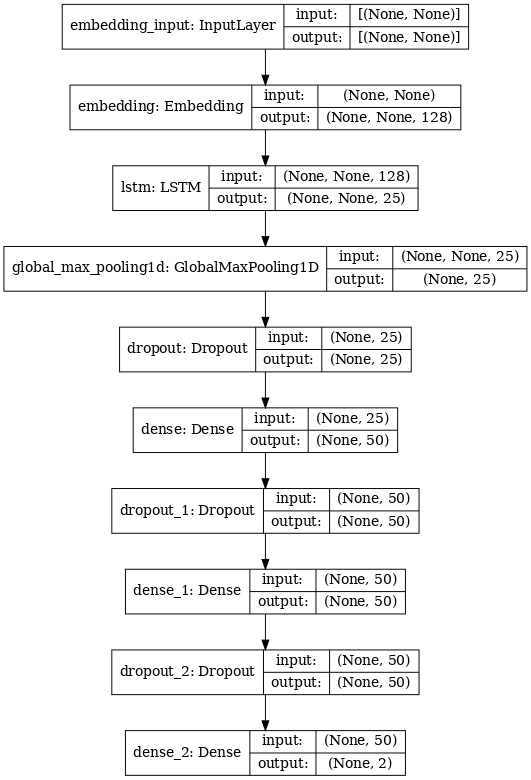

In [5]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=70, )

In [6]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

2022-12-05 01:59:26.766839: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
377/377 [==============================] - 50s 124ms/step - loss: 0.4732 - accuracy: 0.7514 - val_loss: 0.2609 - val_accuracy: 0.8851
Epoch 2/10
377/377 [==============================] - 47s 124ms/step - loss: 0.2036 - accuracy: 0.9212 - val_loss: 0.2401 - val_accuracy: 0.8925
Epoch 3/10
377/377 [==============================] - 47s 124ms/step - loss: 0.0938 - accuracy: 0.9628 - val_loss: 0.3314 - val_accuracy: 0.8910
Epoch 4/10
377/377 [==============================] - 47s 124ms/step - loss: 0.0645 - accuracy: 0.9758 - val_loss: 0.4332 - val_accuracy: 0.8761
Epoch 5/10
377/377 [==============================] - 48s 127ms/step - loss: 0.0426 - accuracy: 0.9832 - val_loss: 0.4883 - val_accuracy: 0.8873
Epoch 6/10
377/377 [==============================] - 48s 127ms/step - loss: 0.0365 - accuracy: 0.9868 - val_loss: 0.5480 - val_accuracy: 0.8903
Epoch 7/10
377/377 [==============================] - 47s 124ms/step - loss: 0.0341 - accuracy: 0.9886 - val_loss: 0.6110 - val_ac

In [7]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test1=np.argmax(y_test, axis=1)
acc = accuracy_score(y_test1, y_pred) 
print('Overall accuracy of RNN: {:.3f}'.format(acc))

Overall accuracy of RNN: 0.882


In [8]:
hidden_features = model.predict(X_test)

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA()
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 1.0

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result)#[:5000]

Variance PCA: 1.0
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6600 samples in 0.003s...
[t-SNE] Computed neighbors for 6600 samples in 0.151s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 6600
[t-SNE] Computed conditional probabilities for sample 2000 / 6600
[t-SNE] Computed conditional probabilities for sample 3000 / 6600
[t-SNE] Computed conditional probabilities for sample 4000 / 6600
[t-SNE] Computed conditional probabilities for sample 5000 / 6600
[t-SNE] Computed conditional probabilities for sample 6000 / 6600
[t-SNE] Computed conditional probabilities for sample 6600 / 6600
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.506573
[t-SNE] KL divergence after 1000 iterations: 0.223311


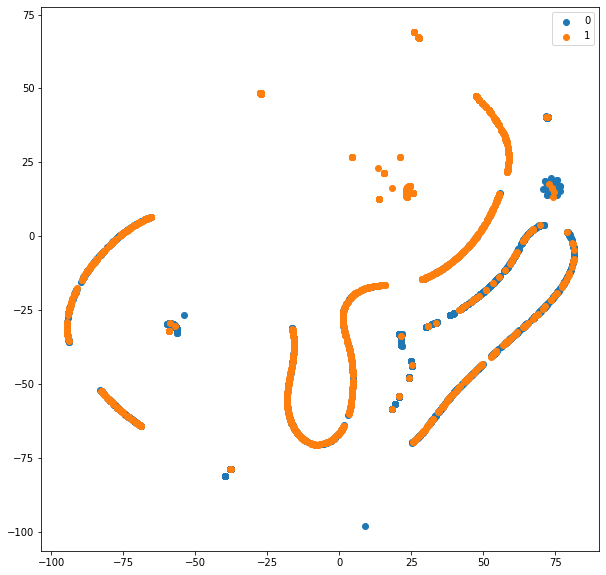

In [10]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline
#  visualize the loss and accuracy 
# for the training and testing data based on the
y_test_cat = np_utils.to_categorical(y_test1, num_classes = 2) #[:5000]
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend()
plt.show()

In [11]:
from keras.backend import clear_session
clear_session()

In [12]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9849
Testing Accuracy:  0.8824


In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, '-o' , label='Training acc')
    plt.plot(x, val_acc, '-o' , label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, '-o', label='Training loss')
    plt.plot(x, val_loss, '-o',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

From the plot we can observer that we have trained our model for too long since the training accuracy is almost reached to 100%.

In [15]:
history1 = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
377/377 [==============================] - 49s 126ms/step - loss: 0.0212 - accuracy: 0.9909 - val_loss: 0.9167 - val_accuracy: 0.8881
Epoch 2/20
377/377 [==============================] - 48s 126ms/step - loss: 0.0267 - accuracy: 0.9913 - val_loss: 0.6218 - val_accuracy: 0.8806
Epoch 3/20
377/377 [==============================] - 48s 127ms/step - loss: 0.0158 - accuracy: 0.9951 - val_loss: 0.7865 - val_accuracy: 0.8851
Epoch 4/20
377/377 [==============================] - 47s 125ms/step - loss: 0.0165 - accuracy: 0.9942 - val_loss: 0.8083 - val_accuracy: 0.8903
Epoch 5/20
377/377 [==============================] - 47s 125ms/step - loss: 0.0165 - accuracy: 0.9938 - val_loss: 0.8588 - val_accuracy: 0.8806
Epoch 6/20
377/377 [==============================] - 47s 126ms/step - loss: 0.0151 - accuracy: 0.9949 - val_loss: 0.9808 - val_accuracy: 0.8813
Epoch 7/20
377/377 [==============================] - 47s 126ms/step - loss: 0.0107 - accuracy: 0.9966 - val_loss: 1.1205 - val_ac

In [16]:
y_pred = model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test1=np.argmax(y_test, axis=1)
acc = accuracy_score(y_test1, y_pred) 
print('Overall accuracy of RNN: {:.3f}'.format(acc))

Overall accuracy of RNN: 0.884


Variance PCA: 1.0
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6600 samples in 0.003s...
[t-SNE] Computed neighbors for 6600 samples in 0.170s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed conditional probabilities for sample 1000 / 6600
[t-SNE] Computed conditional probabilities for sample 2000 / 6600
[t-SNE] Computed conditional probabilities for sample 3000 / 6600
[t-SNE] Computed conditional probabilities for sample 4000 / 6600
[t-SNE] Computed conditional probabilities for sample 5000 / 6600
[t-SNE] Computed conditional probabilities for sample 6000 / 6600
[t-SNE] Computed conditional probabilities for sample 6600 / 6600
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.161163
[t-SNE] KL divergence after 1000 iterations: 0.693530


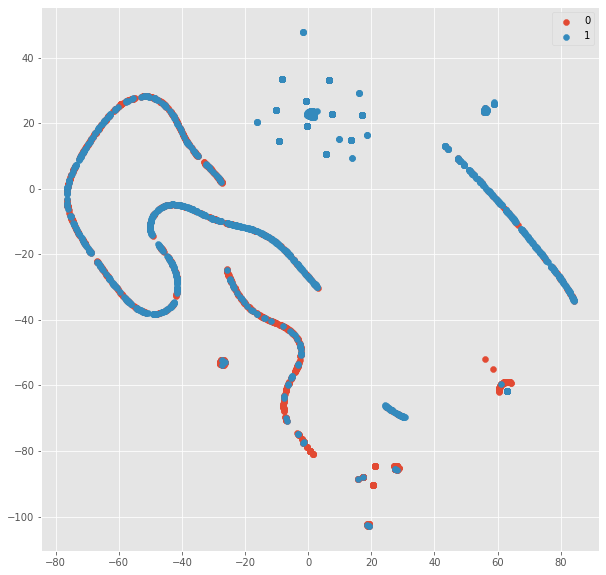

In [17]:
hidden_features = model.predict(X_test)
pca = PCA()
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 1.0

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result)#[:5000]

y_test_cat = np_utils.to_categorical(y_test1, num_classes = 2) #[:5000]
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend()
plt.show()

Training Accuracy: 0.9882
Testing Accuracy:  0.8844


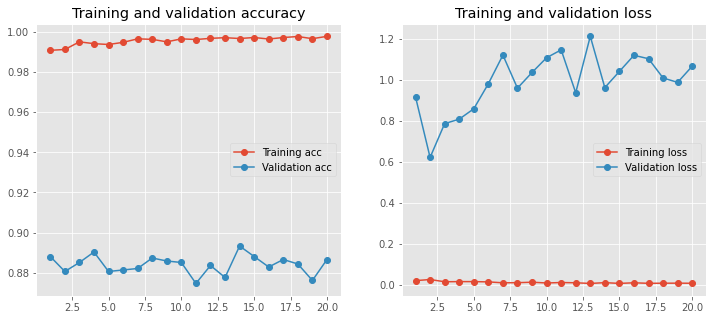

In [18]:
clear_session()
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9a6749d3-7805-4e72-9b13-9d4cebfc5e43' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>